# Chapter 16: Logistic Regression

In this chapter we will attempt to find decsion boundaries in order to make discrete classification decsions.

### Logistic Function

We will use fit a logistic function to our model whose output is the probabilty of being in a certain class

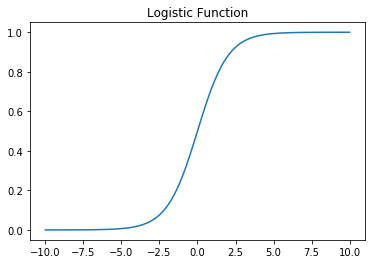

In [1]:
import math, my_utils
def logistic(x):
    return 1 / (1 + math.exp(-x))

n = 100
x = my_utils.linspace(-10, 10, 100)
y = [logistic(x_i) for x_i in x]

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.title("Logistic Function")
plt.draw()